In [1]:
import numpy as np
from scipy.linalg import eigh
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm.notebook import tqdm, trange
import torch.nn.functional as F
import torch.nn as nn
import torch
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
import os
import pickle

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group, get_rank, get_world_size

import seaborn as sns
torch.manual_seed(42)

In [190]:
k = os.getenv("K", 8)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
NUM_EPOCHS = int(os.getenv("NUM_EPOCHS", 10))
PRF_KEY = int(os.getenv("PRF_KEY", 69)) % (2**64 - 1)
ROOT_DIR = os.getenv("ROOT_DIR", "..")
k = int(k)
print(f"K: {k}, Num epochs: {NUM_EPOCHS}")

K: 8, Num epochs: 10


In [191]:
model_name = "meta-llama/Llama-2-7b-hf"
dataset_name = "Skylion007/openwebtext"
model_suffix = model_name.split("/")[-1]
dataset_suffix = dataset_name.split("/")[-1]

dir = f"{ROOT_DIR}/data/{dataset_suffix}_{model_suffix}"

model_dir = f"{ROOT_DIR}/saved_models/{dataset_suffix}_{model_suffix}"

hidden_states = torch.load(f"{dir}/hidden_states.pt")
#embeddings = torch.load(f"{dir}/embeddings_all-mpnet-base-v2.pt")
hidden_states = hidden_states.float()
# embeddings = embeddings.float()

# embeddings = embeddings[:hidden_states.shape[0]]

In [192]:
def ridge_regression(X, Y, alpha):
    d_in = X.shape[1]
    I = torch.eye(d_in, device=X.device)
    W = torch.linalg.solve(X.T @ X + alpha * I, X.T @ Y)
    return W

In [193]:
W_align = torch.load(f"{model_dir}/align_ridge.pt").cpu().T

Bin centers: tensor([-2.,  2.])


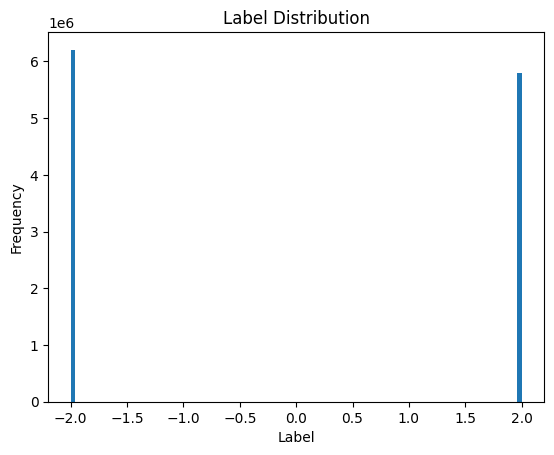

In [230]:

def generate_rand_proj_labels(prf_key, k, quantize=False):
    rng = torch.Generator()
    rng.manual_seed(prf_key)
    W_random, _ = torch.linalg.qr(torch.randn(
        W_align.shape[1], k, generator=rng))
    W_random = W_align @ W_random
    logits = F.linear(hidden_states, W_random.T)
    # quantize logits into equal spaced bins between -1 and 1
    if quantize:
        logits = (logits - logits.mean(dim=1, keepdim=True)) / \
                 (logits.std(dim=1, keepdim=True) + 1e-6)

        # Define bin centers (e.g., from -1 to 1 at 0.5 spacing)
        bin_centers = torch.arange(-2, 2.1, 4, device=logits.device)  # [-1.5, -1.0, ..., 1.5]
        print(f"Bin centers: {bin_centers}")
        # Digitize: assign each value to the nearest bin center
        logits_expanded = logits.unsqueeze(-1)  # (B, k, 1)
        diffs = torch.abs(logits_expanded - bin_centers.view(1, 1, -1))  # (B, k, num_bins)
        bin_indices = torch.argmin(diffs, dim=-1)  # (B, k)
        logits = bin_centers[bin_indices]
    
    return logits



all_labels = generate_rand_proj_labels(PRF_KEY, k, quantize=True)

# Plot the distribution of the labels
plt.hist(all_labels.flatten().numpy(), bins=100)
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

In [231]:
# Create a dataset with the labels
dataset = TensorDataset(hidden_states, all_labels)
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_indices = train_dataset.indices
val_indices = val_dataset.indices

val_hidden_states = hidden_states[val_indices]
val_labels = all_labels[val_indices]

train_hidden_states = hidden_states[train_indices]
train_labels = all_labels[train_indices]


print(f"Train size: {train_size}, Val size: {val_size}")

Train size: 1125000, Val size: 375000


In [232]:
W_proj = ridge_regression(train_hidden_states @ W_align, train_labels, alpha=0.001)

W_proj = W_align @ W_proj

final_matrix = W_proj.T

final_matrix.shape

torch.Size([8, 4096])

Visualize selectors

In [233]:
X_sample_projected = F.linear(val_hidden_states, final_matrix)

In [234]:
print(torch.sign(X_sample_projected[0]) == torch.sign(X_sample_projected[10]))
X_sample_projected[1], X_sample_projected[3]

tensor([False, False, False,  True, False, False,  True,  True])


(tensor([-0.9918,  0.4736, -1.6014, -2.2258,  1.3035,  0.5569,  1.2768,  1.3746]),
 tensor([-1.4612, -1.1112, -1.9507,  1.4847, -0.2737, -0.5326,  2.1896,  1.0964]))

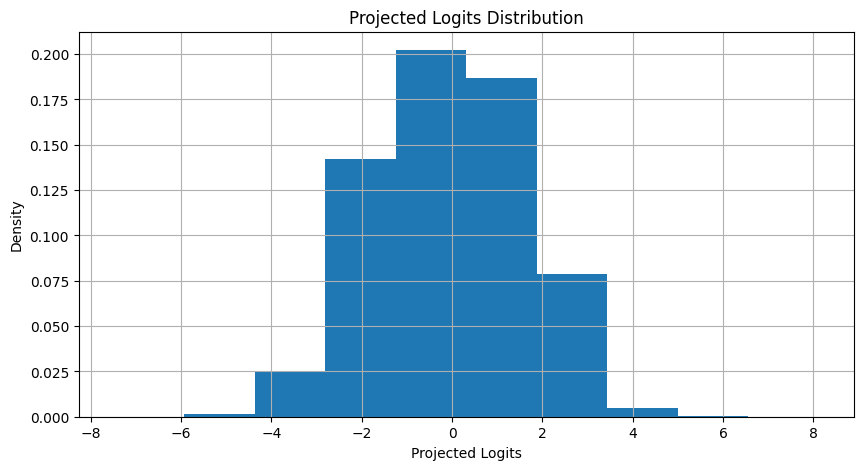

In [235]:
# Plot the distribution of the logits
plt.figure(figsize=(10, 5))
plt.hist(X_sample_projected.flatten().cpu(), bins=10, density=True)
plt.title("Projected Logits Distribution")
plt.xlabel("Projected Logits")
plt.ylabel("Density")
plt.grid()
plt.show()

In [243]:

vocab_size = 32000

def create_watermarking_matrix_v3(hash_key, k, vocab_size, gamma, delta, device, dtype):
    rng = torch.Generator()
    rng.manual_seed(hash_key)
    watermark_matrix = torch.zeros(k, vocab_size, device=device)

    # For each column, randomly assign 0s or 1s with gamma probability
    for i in range(vocab_size):
        watermark_matrix[:, i] = torch.bernoulli(torch.full((k,), gamma), generator=rng)

    watermark_matrix = watermark_matrix * delta

    watermark_matrix = watermark_matrix.to(device)

    return watermark_matrix.to(dtype)

watermark_matrix = create_watermarking_matrix_v3(
    PRF_KEY, k, vocab_size, 1.0, 0.5, final_matrix.device, dtype=final_matrix.dtype)

delta_mat = torch.matmul(watermark_matrix.T, final_matrix)




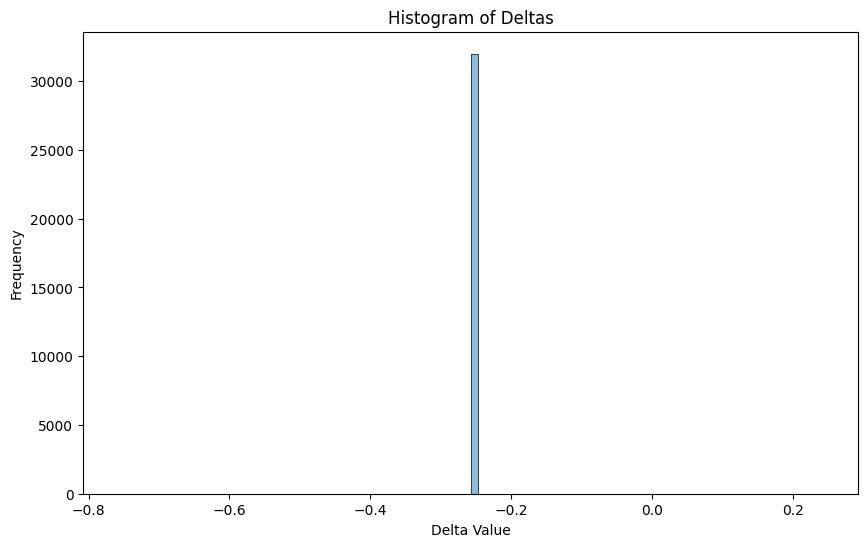

In [246]:
samples = val_hidden_states[:1]

deltas = torch.matmul(samples, delta_mat.T)
deltas = deltas.float().cpu().numpy()
plt.figure(figsize=(10, 6))
sns.histplot(deltas.flatten(), bins=100, kde=True)
plt.title("Histogram of Deltas")
plt.xlabel("Delta Value")
plt.ylabel("Frequency")
plt.show()

Save model

In [247]:
# Make sure the output directory exists
os.makedirs(f"{ROOT_DIR}/output/k{k}_v3", exist_ok=True)


torch.save(final_matrix.cpu(),
           f"{ROOT_DIR}/output/k{k}_v3/final_matrix.pt")